In [1]:
#importing our libraries
import pandas as pd
import seaborn as sns
import cufflinks as cf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
%matplotlib inline
cf.go_offline()

In [2]:
#importing our dataset 
df=pd.read_csv('kijiji.csv',index_col=0)
df.head()

,price,area,location,date
0,500 €,Superficie (mq): 123,Centro,"28 marzo, 03:23"
1,900 €,Superficie (mq): 50,Città Studi / Lambrate,"Oggi, 11:18"
2,635 €,Superficie (mq): 60,Lodi / Ripamonti / Mecenate,"Oggi, 09:16"
3,Contatta l'utente,Superficie (mq): 40,Bicocca / Greco / Viale Monza,"Oggi, 08:06"
4,1.150 €,Superficie (mq): 50,Porta Romana / Monte Nero,"Oggi, 05:05"


# 1-Data Cleaning

In [3]:
#deleting any values without prices and any values before january 
df = df[df.price != "Contatta l'utente"]
df = df[df.date != "22 dicembre, 02:39"]
df = df[df.date != "11 dicembre, 02:56"]
df = df[df.date != "10 dicembre, 15:44"]
df = df[df.date != "10 dicembre, 12:45"]

We need to clean and organize our data for analysis

In [104]:
#take a copy of the dataset
df = df.copy()
#removing any signs or strings not needed converting the strings into floats
df['price'] = df['price'].apply(lambda x: x.replace('€', '').replace('.', '')
                                if isinstance(x, str) else x).astype(float)
df['area'] = df['area'].apply(lambda x: x.replace('Superficie (mq): ', '').replace('.', '')
                                if isinstance(x, str) else x).astype(float)
#converting some italian words of today and yesterday to dates  
df['date'] = df['date'].apply(lambda x: x.replace('Oggi', '15 aprile').replace(',', '')
                                if isinstance(x, str) else x).astype(str)
df['date'] = df['date'].apply(lambda x: x.replace('Ieri', '14 aprile').replace(',', '')
                                if isinstance(x, str) else x).astype(str)
df

,price,area,location,date
144,580.0,20.0,Milano,2020-03-10
258,700.0,20.0,Milano,2020-02-29
337,500.0,20.0,Milano,2020-02-19
149,580.0,22.0,Milano,2020-03-09
156,580.0,22.0,Milano,2020-03-09
...,...,...,...,...
252,500.0,123.0,Centro,2020-03-28
369,2100.0,125.0,Milano,2020-02-13
62,590.0,125.0,~Altre zone,2020-03-31
104,2150.0,130.0,Milano,2020-03-13


Now we will try to work on the date column, we need to convert the data to a datetime format in order to be readable by python

In [5]:
d = {'gennaio':1, 'febbraio':2, 'marzo':3, 'aprile':4}

In [6]:
#split each elemnet in the column
date = df.date.str.split(expand=True)
#rename the columns
date = date.rename(columns={0: "day", 1: "month",2:'time'})
#converting months to numbers
date.month = date.month.map(d)
date

,day,month,time
0,28,3,03:23
1,15,4,11:18
2,15,4,09:16
4,15,4,05:05
5,15,4,04:59
...,...,...,...
452,12,1,03:59
454,11,1,09:14
456,8,1,02:18
457,7,1,21:43


In [7]:
#add a year column
date['year'] = '2020'
#join day month year column
ndate=pd.to_datetime(date[['year', 'month', 'day']])
df['date'] = ndate
df

,price,area,location,date
0,500.0,123.0,Centro,2020-03-28
1,900.0,50.0,Città Studi / Lambrate,2020-04-15
2,635.0,60.0,Lodi / Ripamonti / Mecenate,2020-04-15
4,1150.0,50.0,Porta Romana / Monte Nero,2020-04-15
5,1400.0,80.0,Città Studi / Lambrate,2020-04-15
...,...,...,...,...
452,4800.0,255.0,Centro,2020-01-12
454,350.0,40.0,Porta Genova / Navigli / Corso Italia,2020-01-11
456,3100.0,120.0,Milano,2020-01-08
457,1166.0,50.0,Milano,2020-01-07


Now it's time to work on the outliers 

In [8]:
#setting the parameters
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
#Interquartile range
iqr = q3-q1 
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
#data without ouliers
df = df.loc[(df['price'] > fence_low) & (df['price'] < fence_high)]
df
#for reference: https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm

,price,area,location,date
0,500.0,123.0,Centro,2020-03-28
1,900.0,50.0,Città Studi / Lambrate,2020-04-15
2,635.0,60.0,Lodi / Ripamonti / Mecenate,2020-04-15
4,1150.0,50.0,Porta Romana / Monte Nero,2020-04-15
5,1400.0,80.0,Città Studi / Lambrate,2020-04-15
...,...,...,...,...
447,760.0,70.0,Barona / Giambellino / Lorenteggio,2020-01-12
451,750.0,44.0,Centro,2020-01-12
454,350.0,40.0,Porta Genova / Navigli / Corso Italia,2020-01-11
457,1166.0,50.0,Milano,2020-01-07


we can notice 25 values has been removed

# 2-Data Exploring & Visualization 

Now before splitting the data set to before and after coronavirus outbreak, let's explore some data exploring to be familier with our data first

In [27]:
#Checking the price mean and the correlation between price and area 
print(df['price'].mean())
print(df.corr())

955.4214876033058
          price      area
price  1.000000  0.261033
area   0.261033  1.000000


26% correlation is a very weak one, and it's worth investigating

In [14]:
#first let's sort the data frame by the ascending area values
df = df.sort_values(by='area', ascending=True)

In [28]:
#let's explore the mean price and area for each area in milan
df.groupby('location').mean()

,price,area
location,,
Affori / Bovisa,816.000000,53.000000
Baggio / Forze Armate / Quinto Romano,800.000000,72.142857
Barona / Giambellino / Lorenteggio,806.875000,60.625000
Bicocca / Greco / Viale Monza,940.000000,59.700000
Bonola / Molino Dorino / Lampugnano,1195.000000,72.500000
Centro,629.310345,109.620690
Città Studi / Lambrate,564.384615,47.846154
Garibaldi / Stazione Centrale / Isola,1033.333333,52.166667
Lodi / Ripamonti / Mecenate,978.600000,60.040000


In [77]:
df.groupby('location').mean().iplot()

We can notice that the most expensive areas are (Bonola / Molino Dorino / Lampugnano) (San Siro / Fiera) while the cheapest ones are (Città Studi / Lambrate) and very strangely (Centro), that will be under investigation in the next step when we split the data.
#Note: the milano area is based on user submission of not specifying the zone

In [32]:
#splitting the dataframe
dfb = df[(df['date'] < '2020-02-21')]
dfa = df[(df['date'] >= '2020-02-21')]

In [38]:
print(dfb.info())
print('\n')
print(dfa.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 337 to 369
Data columns (total 4 columns):
price       85 non-null float64
area        85 non-null float64
location    85 non-null object
date        85 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.3+ KB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 144 to 304
Data columns (total 4 columns):
price       278 non-null float64
area        278 non-null float64
location    278 non-null object
date        278 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 10.9+ KB
None


We have 85 online rent postings before the outbreak while strangely we have more than triple the number after for the same time period. 

In [39]:
print(dfb['price'].mean())
print(dfa['price'].mean())

1141.8235294117646
898.4280575539568


Average prices before the outbreak are higher

In [40]:
print(dfb.corr())
print(dfa.corr())

          price      area
price  1.000000  0.555945
area   0.555945  1.000000
          price      area
price  1.000000  0.176422
area   0.176422  1.000000


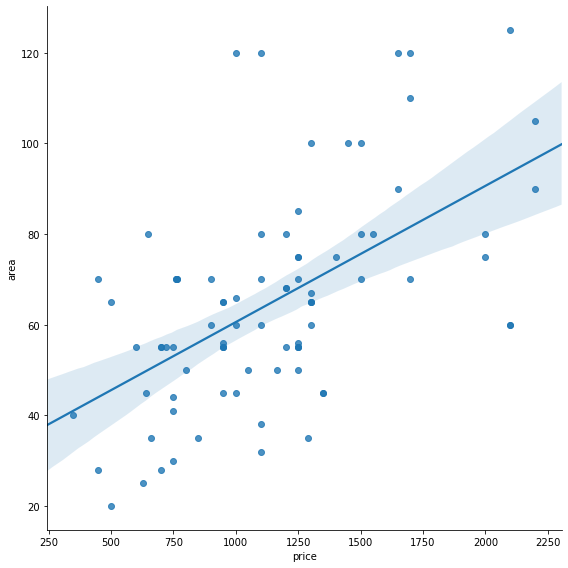

In [54]:
sns.lmplot(x='price',y='area',data=dfb,height=8)

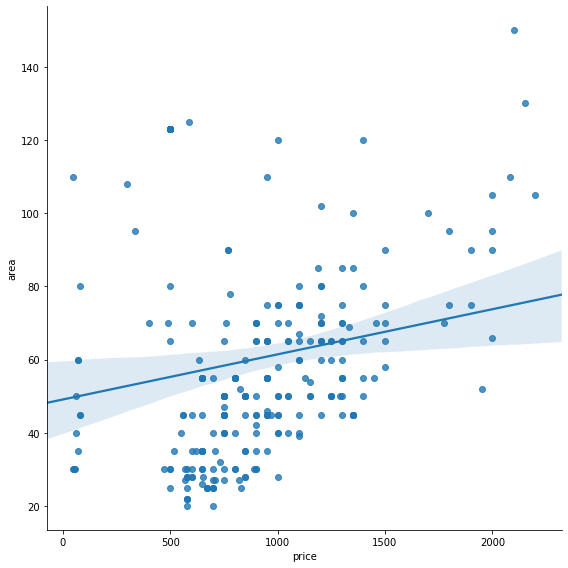

In [55]:
sns.lmplot(x='price',y='area',data=dfa,height=8)

A positive relationship exists with 55% correlation between prices and areas before the outbreak while on the other hand it's almost zero after the outbreak, which suggests that people's pricing behaviors have changed. It's also worth to mention that 55% correlation between price and area is not that strong and it shows how in a lot of tenants can be charged for a lot more than what they get, it's also worth mentioning that house prices doesn't only depend on those features

In [42]:
dfb.groupby('location').mean().iplot()

In [44]:
dfa.groupby('location').mean().iplot()

Here we can clearly see the change in trends, before the outbreak prices in the center was the highest along with sansiro area (~1200), however after the outbreak the prices dropped to almost half in the center and loreto area to reach ~600 with small to medium drops in other areas, however we can notice an increase in the pricesin areas like Bonola / Molino Dorino / Lampugnano

In [53]:
dfb.groupby(['location','area']).mean().iplot()

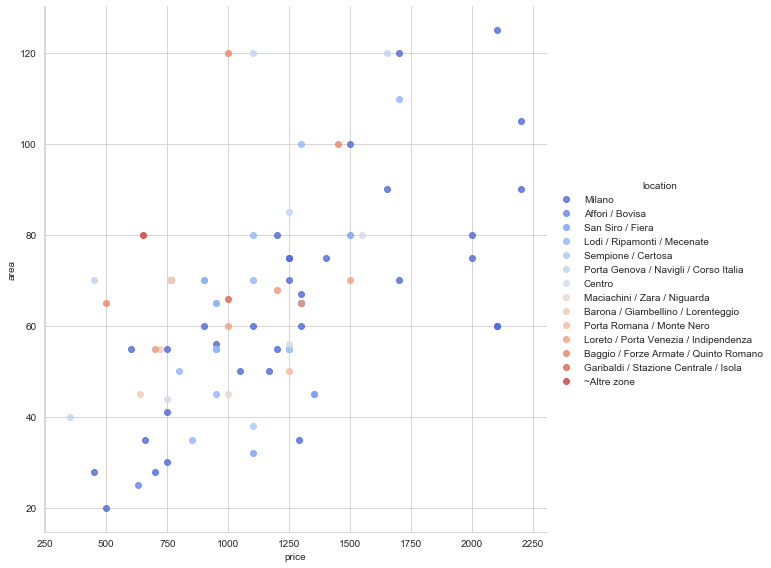

In [78]:
sns.set_style('whitegrid')
sns.lmplot('price','area',data=dfb, hue='location',
           palette='coolwarm',size=8,aspect=1,fit_reg=False)

Here we can explore the change in prices based on apartment area and location, it should be normal to have the same price for the same features in the same location like what we see in (Baggio / Forze Armate / Quinto Romano) or in the center, however there are a lot of variations in the prices in areas like (Porta Genova / Navigli / Corso Italia) or (San Siro / Fiera), that's definitely explains the low correlation number from before, and we should expect higher variations in the after data.

In [46]:
dfa.groupby(['location','area']).mean().iplot()

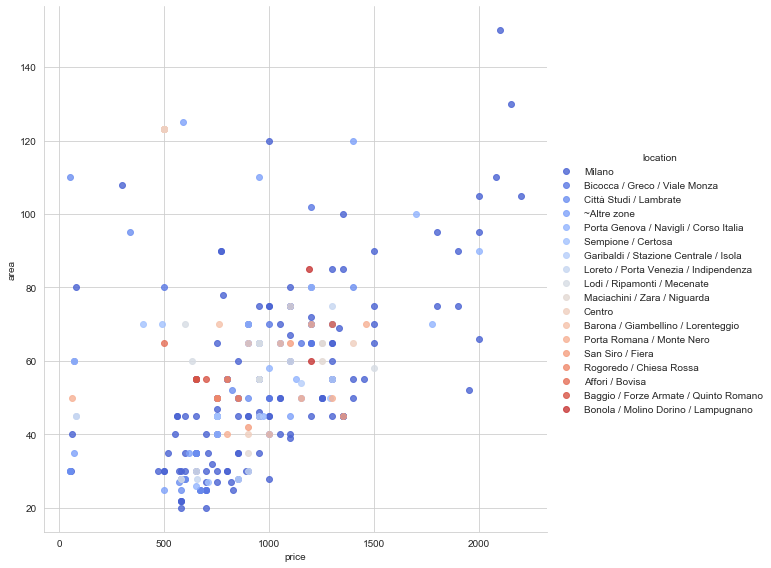

In [79]:
sns.set_style('whitegrid')
sns.lmplot('price','area',data=dfa, hue='location', palette='coolwarm',size=8,aspect=1,fit_reg=False)

As expected, prices disruption, can be due to fear from the country lockdown as workers stay home, and due to business shutdowns, quarantines and curfews. Huge numbers of layoffs will lead to further contraction in consumer spending, which will force landlords to decrease their prices, some has already started to adapt to the new situation and some are still offering the same normal prices, having in mind also that the market for short-term renting is slowing down massively.

# 3-Clustering

In this part we will try to divide the market into distinct subsets of apartments based on their area and price.

In [60]:
#extract the price and area data 
dfbn=dfb[['price','area']]
dfan=dfa[['price','area']]

MinMaxScaler(feature_range = (0, 1)) will transform each value in the column proportionally within the range [0,1]. Use this as the first scaler choice to transform a feature, as it will preserve the shape of the dataset (no distortion)

In [74]:
#starting with the data from before the outbreak
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(dfbn)
#chossing 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_df)

In [75]:
cluster_dfb = dfbn.copy(deep=True)
cluster_dfb['cluster'] = kmeans.labels_
cluster_dfb.head()

,price,area,cluster
337,500.0,20.0,3
343,630.0,25.0,3
355,700.0,28.0,3
327,450.0,28.0,3
329,750.0,30.0,3


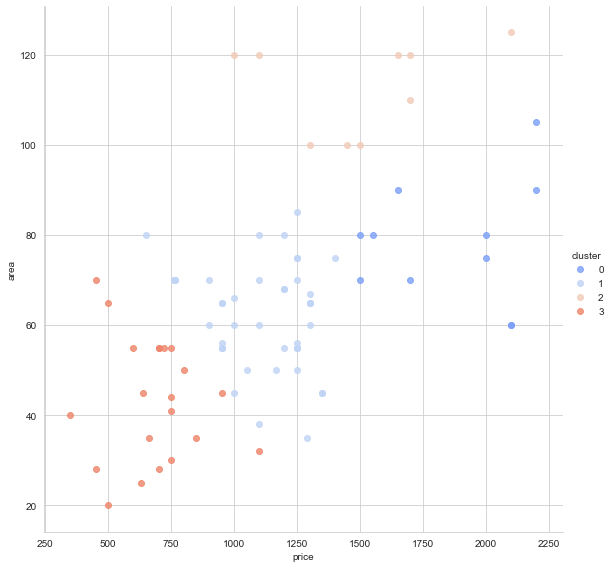

In [80]:
#visualizing the clusters
sns.set_style('whitegrid')
sns.lmplot('price','area',data=cluster_dfb, hue='cluster',
           palette='coolwarm',size=8,aspect=1,fit_reg=False)

Cluster 0: prices(1500-2250)€, area(60-105)mq, this cluster has small apartments with high prices, those usually are concentrated in expensive neighborhood or in the center.

Cluster 1: prices(625-1500)€, area(35-86)mq, this is the medium cluster, you can have small apartments with higher prices than cluster 3 for the sake of a better neighborhood.

Cluster 2: prices(1000-2200)€, area(100-130)mq, this cluster kinda have a correlated relationship, big apartments with high prices.

Cluster 3: prices(375-1100)€, area(20-70)mq, this cluster has also a positive relationship, small apartments with low price range, that is usually in areas far from the center.

In [95]:
#join the location to the cluster data
cluster_dfb['location'] = dfb['location']

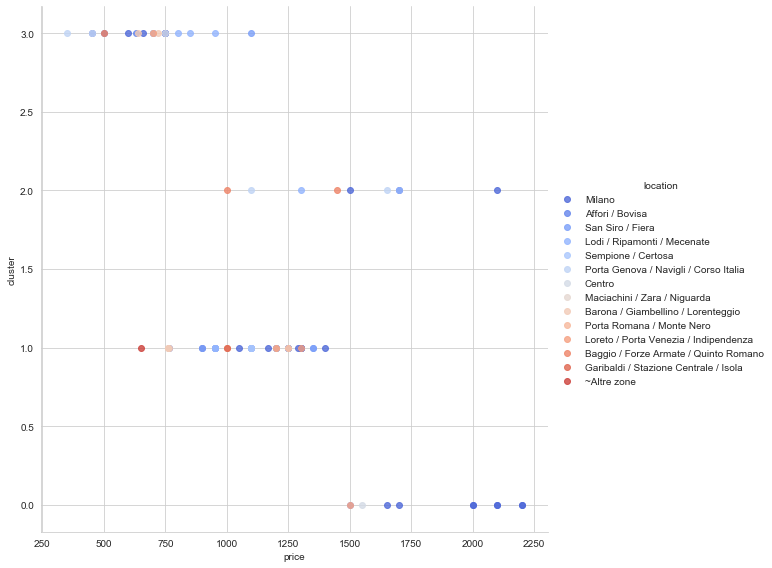

In [107]:
#let us print the prices clustered based on the location 
sns.set_style('whitegrid')
sns.lmplot('price','cluster',data=cluster_dfb, hue='location',
           palette='coolwarm',size=8,aspect=1,fit_reg=False)

Clusters are as before only here we can see each cluster contins postings in which areas in the city, cluster 0 as predicted has apartments in the center, we can also assume from this results that the Milano segment is associated with the center and expensive neighborhoods.

In [71]:
#doing the same thing for the other dataset
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(dfan)
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_df)

In [72]:
cluster_dfa = dfan.copy(deep=True)
cluster_dfa['cluster'] = kmeans.labels_
cluster_dfa.head()

,price,area,cluster
144,580.0,20.0,0
258,700.0,20.0,0
149,580.0,22.0,0
156,580.0,22.0,0
120,580.0,22.0,0


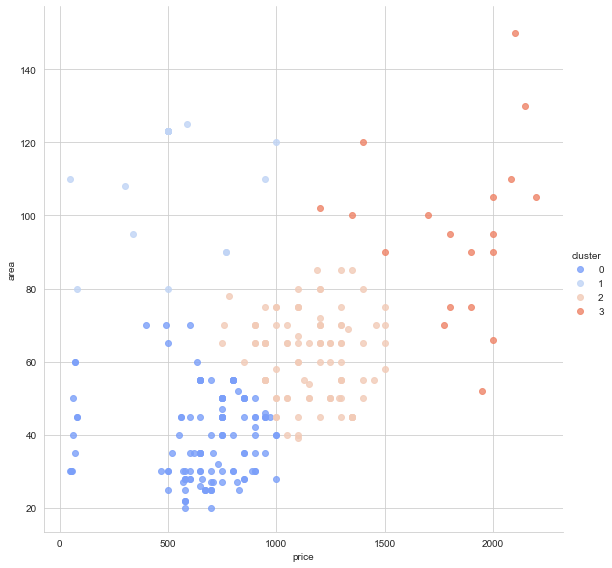

In [81]:
sns.set_style('whitegrid')
sns.lmplot('price','area',data=cluster_dfa, hue='cluster',
           palette='coolwarm',size=8,aspect=1,fit_reg=False)

Cluster 0: prices(100-1000)€, area(20-70)mq, this cluster has small apartments with very low price range, that is usually in areas far from the center.

Cluster 1: prices(100-1000)€, area(80-125)mq, this cluster has bigger apartments with the same low price range from before, which indicates that maybe some apartments had to lower their range of prices after the outbreak.

Cluster 2: prices(750-1500)€, area(40-86)mq, this is the medium cluster, you can have small apartments with higher prices than cluster 3 for the sake of a better neighborhoods.

Cluster 3: prices(1200-2250)€, area(55-150)mq, this cluster has big range from small apartments to bigger ones, however with high prices, those usually are concentrated in expensive neighborhoods or in the center.

We can notice the price range went down in comparison from the dataset before the outbreak, 500€ drop shows the fall in prices, and maybe its not as big as the drop in sales. 

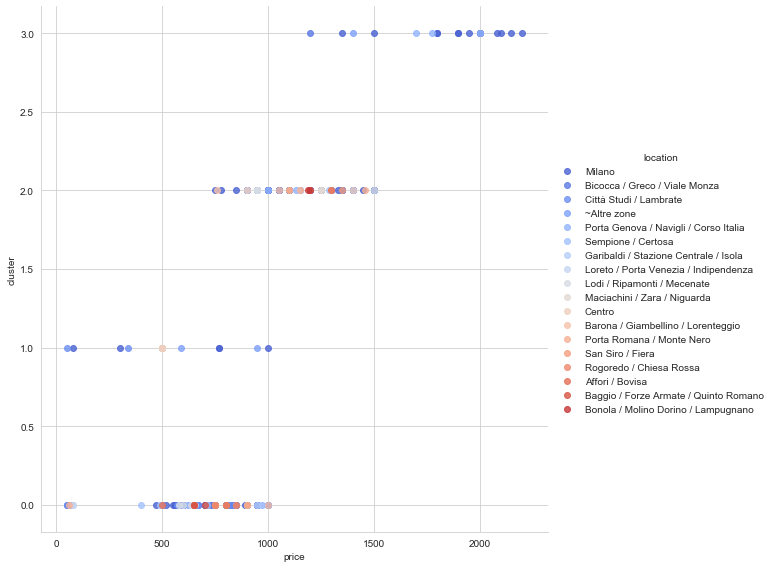

In [109]:
#join the location to the cluster data
cluster_dfa['location'] = dfa['location']
sns.set_style('whitegrid')
sns.lmplot('price','cluster',data=cluster_dfa, hue='location',
           palette='coolwarm',size=8,aspect=1,fit_reg=False)

In this last representation, cluster 3 as shown before has the highest prices, however, the prices are not the center anymore as before the outbreak, they are in areas like Biccoca and Citta Studi, concentrated near universities, while the center prices has shown a huge drop

# 4-Conclusion

Our data and our analysis showed that the market bevaiour has definietly changed, some landlords has already started to lower their renting price for their apartments, the data also showed that the number of postings after the outbreat is triple the number before which indicated a huge drop in sales. 

Property renting and buying platform Idealista.com reported in early April that the effects of the coronavirus crisis have yet to be noticed on the market, although they warned the next quarter will probably shed more light on the situation.

According to their data from the first quarter of 2020, house prices across Italy dropped by 0.4 percent, with the average price for second-hand properties now standing at €1,699 per square meter (annual decrease of 2 percent).

## Future work

If you like the idea of investigating the market trends, having more features of each apartment is definitely recommended, playing with dummy variables to turn the location to a measurable variable can be an interesting idea, collecting more data after couple of month to have a deeper look is also recommended. 